In [1]:
# Training NN with Elegy then do HMC with Oryx on Mana
# Author: Peter Oct 28 2021
# Requirements: 
#!module load system/CUDA/11.0.2 
#!pip install --upgrade jax jaxlib==0.1.68+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html 
#!pip install tensorflow-io oryx elegy

import os
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad
assert jax.default_backend() == 'gpu'

import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
from functools import partial

import elegy # pip install elegy. 

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import oryx  # pip install oryx
from oryx.core.ppl import random_variable
from oryx.core.ppl import log_prob
from oryx.core.ppl import joint_sample
from oryx.core.ppl import joint_log_prob
from oryx.core.ppl import block
from oryx.core.ppl import intervene
from oryx.core.ppl import conditional
from oryx.core.ppl import graph_replace
from oryx.core.ppl import nest
#tfd = oryx.distributions
state = oryx.core.state
ppl = oryx.core.ppl


def load_data_ams():
    """ Load AMS data from Claudio."""
    filename = '../data/BR2461.dat'
    alpha, cmf = 69.19, 5.17 # These are fixed for the current experiment.
    dataset_ams = np.loadtxt(filename) # Rigidity1, Rigidity2, Flux, Error
    r1, r2 = dataset_ams[:,0], dataset_ams[:,1]
    bins = np.concatenate([r1[:], r2[-1:]])
    observed = dataset_ams[:,2]   # Observed Flux
    uncertainty = dataset_ams[:,3]
    assert len(bins) == len(observed)+1
    return bins, observed, uncertainty, alpha, cmf

def load_preprocessed_data_ams():
    """ Load AMS data along with hardcoded auxiliary vectors for ppmodel."""
    bins, observed, uncertainty, alpha, cmf = load_data_ams()
    if False:
        pass
        # Need to compute this once and then hardcode results.
        #xloc = np.sort(np.concatenate([jnp.arange(245), bins+1e-12])) # Both the lattice and the given bins. Add epsilon to bin to distinguish it; shouldn't affect result.
        #iloc = jnp.where(xloc % 1 > 0)[0] # Throws error https://github.com/google/jax/issues/4309. Just hardcode result as a quick workaround.
        #print(iloc) # Hardcode this below to make JAX happy. 
    else:
        # Hardcode a list containing the lattice of range(245) and bin edges from the AMS data.
        xloc = jnp.sort(jnp.concatenate([jnp.arange(245), bins])) 
        # Hardcode the indices of the AMS bin edges in this list, so that we can integrate between them.
        iloc = [  2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  14,  15,
                      17,  18,  19,  21,  22,  24,  26,  27,  29,  31,  33,  35,
                      37,  39,  41,  43,  45,  48,  50,  53,  55,  58,  61,  64,
                      68,  71,  75,  78,  82,  87,  91,  96, 101, 106]
        #slices = [slice(iloc[i], iloc[i+1]) for i in range(45)] # These are the slices for each bin.
    return xloc, iloc, observed, uncertainty, alpha, cmf

def remove_consecutive_duplicates(samples):
    ''' 
    Remove consecutive duplicate rows from array. This means sample from MCMC was rejected.
    Input:
        samples = 2d array, where each row is a sample
    Returns:
        rval = 2d array with consecutive duplicate rows removed
    '''
    consecutive_repeat_rows = np.all(samples[1:,:] == samples[:-1,:], axis=1)
    return samples[1:,:][~consecutive_repeat_rows, :]


def define_target_log_prob(model, xloc, iloc, observed, uncertainty, alpha, cmf, key):
    
    def target_log_prob(xs):
        
        # Include logprior in loglikelihood. This keeps HMC from going off into no-mans land.
        penalty = 1e9
        nlogprior = 0.
        for i in range(5):
            nlogprior += penalty * (jnp.minimum(0., xs[i])) # Penalty for being <0
            nlogprior += penalty * (jnp.maximum(1., xs[i]) - 1.)  # Penalty for being >1
        
        # Define random variables. Set these using oryx.core.intervene.
        alpha_key, cmf_key, obs_key, unc_key = random.split(key, 4)
        alpha_norm = random_variable(tfd.Uniform(0., 1.), name='alpha_norm')(alpha_key)
        cmf_norm = random_variable(tfd.Uniform(0., 1.), name='cmf_norm')(cmf_key)
        low, high = [0.]*45, [1e8]*45
        observed = random_variable(tfd.Independent(tfd.Uniform(low,high), reinterpreted_batch_ndims=1), name='observed')(obs_key)
        uncertainty = random_variable(tfd.Independent(tfd.Uniform(low,high), reinterpreted_batch_ndims=1), name='uncertainty')(unc_key)

        # Make NN predictions.
        xs = jnp.concatenate([jnp.array([alpha_norm, cmf_norm]), xs]) # Create 7d input to NN.
        yhat = model.predict(xs)
        #outputs = vmap(partial(mlp))(xs) # 245 outputs

        yhat = jnp.exp(yhat) - 1. # Undo logp1 transform of target output. 
        # Interpolate to get predicted flux at both lattice and bin points.
        yloc = jnp.interp(xloc, jnp.arange(245), yhat) 
        # Integrate over bin regions, and compare to observed to get likelihood.
        nloglikelihood = 0.0
        for i in range(45):
            # Integrate over bin by trapezoid method.
            predicted : float = jnp.trapz(yloc[iloc[i]:iloc[i+1]], x=xloc[iloc[i]:iloc[i+1]])
            # Use equation provided by Claudio for likelihood of bin.
            nloglikelihood += ((predicted - observed[i])/uncertainty[i])**2
            
        return nloglikelihood + nlogprior#jnp.exp(loglikelihood) # Oryx expects likelihood.
        #return random_variable(tfd.Independent(tfd.Normal(loc=outputs, scale=1), reinterpreted_batch_ndims=1), name='y')(label_key)

    alpha_norm = (alpha - 20.) / 55. # Min max scaling
    cmf_norm = (cmf - 4.5) / 4. # Min max scaling
    target_log_prob = intervene(target_log_prob, alpha_norm=alpha_norm, cmf_norm=cmf_norm, observed=observed, uncertainty=uncertainty) 
    #target_log_prob = partial(target_log_prob, key=key)
    return target_log_prob

# Load trained NN model that maps 7 parameters to predicted flux at rigidity vals range(245).
model = elegy.load('./my_model')
model.run_eagerly = True # Settable attribute. Required to be true for ppmodel.

# Load observation data.
xloc, iloc, observed, uncertainty, alpha, cmf = load_preprocessed_data_ams()

# Initialize target_log_prob
target_log_prob = define_target_log_prob(model, xloc, iloc, observed, uncertainty, alpha, cmf, key=random.PRNGKey(0))

In [8]:
MIN_VALS = np.array([50., 0.2, 0.2, 0.2, 0.2])
MAX_VALS = np.array([250., 2., 2.3, 2., 2.3])

print(target_log_prob(MIN_VALS), target_log_prob(MAX_VALS))
x = np.linspace(MIN_VALS, MAX_VALS, 100)
y = jax.vmap(target_log_prob)(x)
plt.plot(y)


49000000000.0 253600000000.0


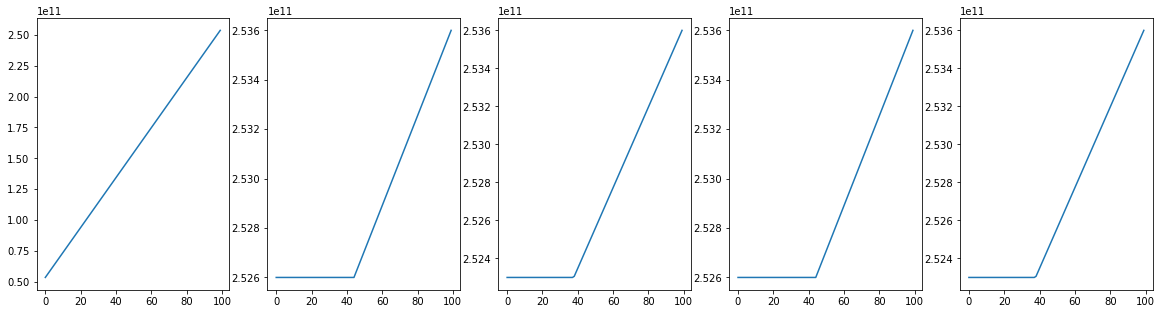

In [30]:
MIN_VALS = np.array([50., 0.2, 0.2, 0.2, 0.2])
MAX_VALS = np.array([250., 2., 2.3, 2., 2.3])
START =  MAX_VALS #MAX_VALS - MIN_VALS

plt.figure(figsize=(20, 5))
for i in range(5):
    p1 = START.copy()
    p1[i] = MIN_VALS[i]
    p2 = START.copy()
    p2[i] = MAX_VALS[i]
    x = np.linspace(p1, p2, 100)
    y = jax.vmap(target_log_prob)(x)
    plt.subplot(1,5,i+1)
    plt.plot(y)
    

In [29]:
p1, p2

(array([200. ,   1.8,   2.1,   1.8,   0.2]),
 array([200. ,   1.8,   2.1,   1.8,   2.3]))

In [ ]:
%%time

# Hyperparameters
num_results = 10000
num_burnin_steps = 500
step_size = 5e-4 # This was optimized by DASSA on 400steps
num_leapfrog_steps=1000
num_adaptation_steps=400 #Somewhat smaller than number of burnin
target_accept_prob=0.7
seed = 5
time = datetime.now().strftime("%m-%d--%H-%M-%S")
key = random.PRNGKey(seed)

@jit
def run_chain(key, state):
    # Example from https://colab.research.google.com/github/tensorflow/probability/blob/master/spinoffs/oryx/examples/notebooks/probabilistic_programming.ipynb#scrollTo=nmjmxzGhN855
    def trace_fn(_, results):
        return [results.inner_results.accepted_results.target_log_prob,
                results.inner_results.accepted_results.step_size,
               ]
    
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
                #tfp.mcmc.HamiltonianMonteCarlo(flat_log_prob, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps),
                tfp.mcmc.HamiltonianMonteCarlo(target_log_prob, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps),
                num_adaptation_steps=num_adaptation_steps,
                target_accept_prob=target_accept_prob)
    
    samples, results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        kernel=kernel,
        trace_fn=trace_fn,
        current_state=state,
        seed=key)
    
    log_probs, step_sizes = results
    return samples, log_probs, step_sizes

state = 0.5*jnp.ones((5,), dtype='float32')
unnormalized_samples, log_probs, step_sizes = run_chain(key, state)

# De-normalize samples.
unnormalized_samples = unnormalized_samples.to_py()
#MIN_VALS = np.array([20., 4.5, 50., 0.2, 0.2, 0.2, 0.2])
#MAX_VALS = np.array([75., 8.5, 250., 2., 2.3, 2., 2.3])
MIN_VALS = np.array([50., 0.2, 0.2, 0.2, 0.2])
MAX_VALS = np.array([250., 2., 2.3, 2., 2.3])
RANGE_VALS = MAX_VALS - MIN_VALS
all_samples = unnormalized_samples * RANGE_VALS + MIN_VALS

# Remove duplicates.
samples = remove_consecutive_duplicates(all_samples)
print(f'Acceptance rate: {len(samples)/len(all_samples)}. Decrease step_size to increase rate.')

# Save samples.
np.savetxt(fname=f'results/samples_{num_results}_{num_burnin_steps}_{step_size}_{num_leapfrog_steps}_{num_adaptation_steps}_{target_accept_prob}_{seed}.csv', X=samples)

# Plot marginals.
parameter_names = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr']
plt.figure(1, figsize=(24, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.hist(samples[:, i])
    plt.xlabel(parameter_names[i])
    #plt.xlim((MIN_VALS[i], MAX_VALS[i]))
plt.savefig(fname=f'results/marginals_{num_results}_{num_burnin_steps}_{step_size}_{num_leapfrog_steps}_{num_adaptation_steps}_{target_accept_prob}_{seed}.pdf', bbox_inches='tight')
# Plot trajectories
plt.figure(2, figsize=(24, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(samples[:, i])
    plt.xlabel('Iteration')
plt.savefig(fname=f'results/trajectory_{num_results}_{num_burnin_steps}_{step_size}_{num_leapfrog_steps}_{num_adaptation_steps}_{target_accept_prob}_{seed}.pdf', bbox_inches='tight')


2518.0344


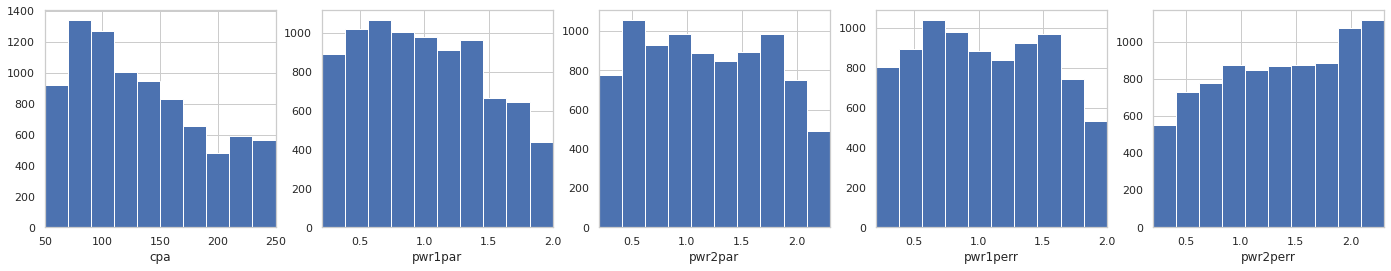

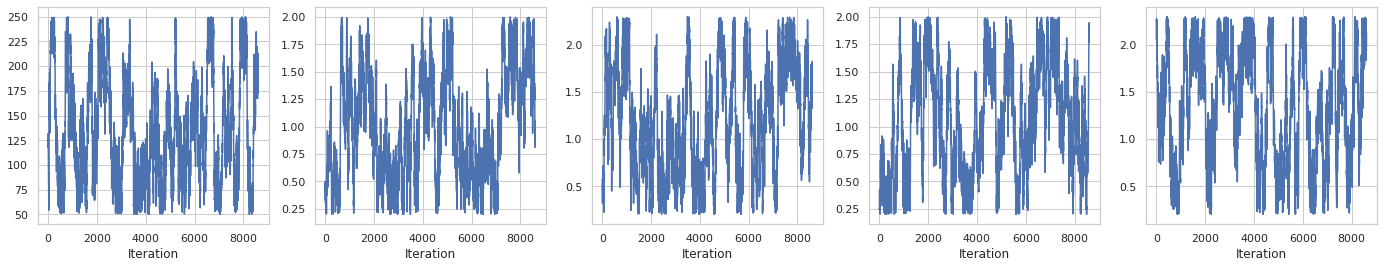

In [17]:

# Plot marginals.
parameter_names = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr']
plt.figure(1, figsize=(24, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.hist(samples[:, i])
    plt.xlabel(parameter_names[i])
    plt.xlim((MIN_VALS[i], MAX_VALS[i]))
#plt.savefig(fname=f'results/marginals_{num_results}_{num_burnin_steps}_{step_size}_{num_leapfrog_steps}_{num_adaptation_steps}_{target_accept_prob}_{seed}.pdf', bbox_inches='tight')


In [ ]:
time